In [1]:
import csv

In [2]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.spatial.distance as distance

n = 100
X = np.random.uniform(0,1,(n,2))
# X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
# X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig1 = plt.scatter(X[:,0], X[:,1])
fig1.axes.set_aspect('equal')
plt.savefig('orginal_dataset_rips.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [3]:
nnz_ = []
tlist = []
lr = 1e-2 # persistence penalty


t0 = time.monotonic()
DX = distance.squareform(distance.pdist(X))
rX = bats.enclosing_radius(bats.Matrix(DX))
F, imap = bats.LightRipsFiltration_extension(bats.Matrix(DX), rX , 2)
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
#print("initialization: {} sec.".format(t1-t0))
F_old = F

iter_times = 10
for i in range(iter_times):
    t_iter = []
    nnz_iter = []
    #print("iter", i)
    # Optimize H1 length
    # get 1-dimensional pairs
    t0 = time.monotonic()
    ps = R.persistence_pairs(1)
    t1a = time.monotonic()
    #print("\tfind pairs: {} sec.".format(t1a - t0))
    
    t0b = time.monotonic()
    complex_old = F_old.complex() # complex of filtration
    filtration_vals_old = F_old.vals(1) # filtration vals at dimension 1
    
    # change the posistion of two vertices 
    # that are related to the birth of the persistence pair

    #print("rX = ", rX)
    for p in ps:
        if p.length() > 0:
        # if p.length() > 0 and np.abs(p.birth() - rX) > 1e-4:
            #print(p)
            d = p.dim()
            # get indices of two vertices of the (birth) edge 
            bi = p.birth_ind() # index of birth edge 
            [birth_vertex1_i, birth_vertex2_i] = complex_old.get_simplex(1, bi)
            # Gradient Descent
            grad_div_2 = 2 * (p.death() - p.birth())* (X[birth_vertex1_i] - X[birth_vertex2_i])
            X[birth_vertex1_i] -=  (lr/ filtration_vals_old[bi]) * (grad_div_2)
            X[birth_vertex2_i] +=  (lr/ filtration_vals_old[bi]) * (grad_div_2)
            #print("update birth success")
            # get the death index of related edge
            if p.death_ind() > len(imap[d+1])-1:
                print("death index exceed limit: ", p.death_ind()) 
                print("p is ", p)
            
            if p.death() != float('inf') and p.death_ind() <= len(imap[d+1])-1:
                di = imap[d+1][p.death_ind()] # maps death_ind to the death edge (related to the 2-simplex destroys H1)
                # get index of two vertices of the (birth) edge 
                [death_vertex1_i, death_vertex2_i] = complex_old.get_simplex(1, di)
                # Gradient Descent
                grad_div_2 = 2 * (p.death() - p.birth()) *  (X[death_vertex1_i] - X[death_vertex2_i])
                X[death_vertex1_i] +=  (lr/ filtration_vals_old[di]) * (grad_div_2)
                X[death_vertex2_i] -=  (lr/ filtration_vals_old[di]) * (grad_div_2)
                #print("update death success")
            
        
    t1b = time.monotonic()
    #print("\tUpdate Dataset: {} sec.".format(t1b - t0b))
    
    # extend filtration
    t0c = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F_new, imap = bats.LightRipsFiltration_extension(bats.Matrix(DX), rX, 2)
    t1c = time.monotonic()
    #print("\textension: {} sec.".format(t1c - t0c))
    
    # Rebuild
    t0_reb = time.monotonic()
    R_reb = bats.reduce(F_new, bats.F2()) # reduce with F2 coefficients
    t1_reb = time.monotonic()
    t_iter.append(t1_reb - t0_reb)
    nnz_iter.append(np.sum(R_reb.nnz_U() + R_reb.nnz_R()))
    
    
    # Find Updating Information and Update
    t0d = time.monotonic()
    UI = bats.UpdateInfoLightFiltration(F_old, F_new)
    R.update_filtration_general(UI)
    t1d = time.monotonic()
    #print("\tupdate: {} sec.".format(t1e - t0e))
    
    # Record updating time and nnz
    nnz_iter.append(np.sum(R.nnz_U() + R.nnz_R()))
    t_iter.append(t1d - t0d)
    
    tlist.append(t_iter)
    nnz_.append(nnz_iter)
    
    # Set old Filtration    
    F_old = F_new
    
    t1 = time.monotonic()
    #print("All: {} sec.".format(t1-t0))

In [4]:
header = ['rebuild','update','nnz_reb', 'nnz_upd'] # set header of csv file
data = []

with open('opt_enc_rips.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    
    # write the header
    writer.writerow(header)
    
    data = np.concatenate((tlist, nnz_), axis=1)
    
    # write multiple rows
    writer.writerows(data)

In [5]:
import pandas as pd
df = pd.read_csv('opt_enc_rips.csv')
df

,rebuild,update,nnz_reb,nnz_upd
0,0.449734,0.084840,1522762.0,1524009.0
1,0.382177,0.064135,1507233.0,1508551.0
2,0.320435,0.082473,1497773.0,1490913.0
3,0.324213,0.119659,1489249.0,1481864.0
4,0.302962,0.099619,1484633.0,1460938.0
...,...,...,...,...
95,0.274233,0.132834,1498801.0,1743871.0
96,0.279349,0.131164,1686567.0,1761196.0
97,0.267979,0.126614,1553083.0,1766116.0
98,0.264723,0.103572,1655778.0,1746657.0


In [6]:
fig2 = plt.scatter(X[:,0], X[:,1])
fig2.axes.set_aspect('equal')
plt.savefig('optimized_dataset_rips.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [47]:
fig = plt.scatter(range(100) , np.array(df['rebuild']), label = 'rebuild')
plt.scatter(range(100) , np.array(df['update']), label = 'update')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('time')
plt.savefig('rips_opt_comparison.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [16]:
np.mean(np.array(df['rebuild']) / np.array(df['update']))

2.5362854852004646

## Observation
Updating time have a linear relationship between the number of non-zeros. 

In [27]:
from scipy.stats import spearmanr
corr1, _ = spearmanr(np.array(df['rebuild']), np.log(np.array(df['nnz_reb'])))
print('Spearmans correlation: %.3f' % corr1)

corr2, _ = spearmanr(df['update'], np.log(df['nnz_upd']))
print('Spearmans correlation: %.3f' % corr2)
corr1, corr2

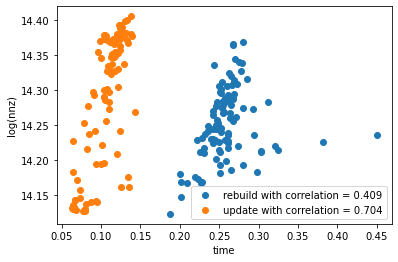

In [40]:
plt.scatter(df['rebuild'], np.log(df['nnz_reb']), label = 'rebuild with correlation = %.3f' % corr1)
plt.scatter(df['update'], np.log(df['nnz_upd']), label = 'update with correlation = %.3f' % corr2)
plt.xlabel('time')
plt.ylabel('log(nnz)')
plt.legend()

Spearmans correlation: 0.409
Spearmans correlation: 0.704


(0.4092169216921691, 0.7035223522352234)

In [35]:
spearmanr?

In [ ]:
fig3 = plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.title('Sum of non-zeros in U and R v.s. number of iterations n')
plt.plot(np.arange(iter_times), nnz_, c = 'g')
plt.xlabel('number of iterations n')
plt.ylabel('number of non-zeros')


plt.subplot(2, 1, 2)
plt.title('Updating Time v.s. Sum of non-zeros of U and R')
plt.scatter(nnz_, tlist, c = 'r')
plt.xlabel('number of non-zeros')
plt.ylabel('Time')

fig3.tight_layout()
plt.savefig('opt_rips_results.png')
plt.clf()